In [99]:
import sys
sys.path.append("../src")

from __future__ import division

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import multiresolutionimageinterface as mir
from multiprocessing import Process, Queue, JoinableQueue, Value, Manager

from threading import Thread
from functools import partial
from scipy import ndimage

class WSIParallelSampler(object):
    """
    Sampler object, uses multiresolutionimageinterface for sampling.
    """

    def __init__(self, filename, data_level, X=None, multiprocess=True, n_producers=2, max_queue_size=None):
        """
            filename string:path to the WSI image (generally a .tif)
            data_level: integer data level to load patches from
        """
        self.filename = filename
        self.data_level = data_level
        self.dims = None

        assert data_level > -1
        self.multiprocess = multiprocess
        self.n_producers = n_producers

        if max_queue_size is None:
            self.max_queue_size = n_producers*4
        else:
            self.max_queue_size = max_queue_size

    def __len__(self):
        return len(self.X)
    

    def __iter__(self):
        
        # Call set_todo_positions first!
        assert self.X is not None
        #m = Manager()
        #queue = m.Queue(maxsize=self.max_queue_size)
        #queue = Queue()
        queue = JoinableQueue(maxsize=1)

        job_queue = self._start_producers(queue)

        # Run as consumer (read items from queue, in current thread)
        
        cache_queue = JoinableQueue(maxsize=self.max_queue_size)
        
        def batcher(queue, cache_queue):
            for x in xrange(len(self.X)):
                job_index, item = queue.get()
                cache_queue.put((job_index, item))
                time.sleep(0.1)
                queue.task_done()
                #print 'batched', x
            
        
        
        p = Thread(target=batcher, args=(queue,cache_queue), name='Batcher')
        # Make the thread daemon, so the main process can die without these finishing
        p.daemon = True
        p.start()

        
        
        for x in xrange(len(self.X)):
            job_index, item = cache_queue.get()
            #print "GET", job_index
            if job_index != x:
                print "Wrong order!"
            yield item # Yield the item to the consumer (user)
            cache_queue.task_done()

        queue.close()
        job_queue.close()
        cache_queue.close()


    def _start_producers(self, result_queue):
        n_workers = self.n_producers
        jobs = Queue()

        # Flag used for keeping values in queue in order
        last_queued_job = Value('i', -1)
        self.order_lock = last_queued_job

        # Add jobs to queue
        for job_index, x in enumerate(self.X):
            jobs.put( (job_index,x) )
            
        # Add poison pills to queue (to signal workers to stop)
        for i in xrange(n_workers):
            jobs.put((-1,None))

        produce = partial(_produce_helper,
            filename=self.filename,
            data_level=self.data_level,
            jobs=jobs,
            result_queue=result_queue,
            last_queued_job=last_queued_job)

        # Start worker processes or threads
        for i in xrange(n_workers):
            name = "ParallelSampler worker {0}".format(i)
        
            if self.multiprocess:
                p = Process(target=produce, args=(i,), name=name)
            else:
                p = Thread(target=produce, args=(i,), name=name)

            # Make the process daemon, so the main process can die without these finishing
            p.daemon = True
            p.start()

        return jobs
    
    def get_image_dimensions(self):
        r = mir.MultiResolutionImageReader()
        img = r.open(self.filename)
        dims = img.getLevelDimensions(self.data_level)
        img.close()
        return dims
    
    # Tuples of X, Y, width, height
    # where to extract areas in WSI.
    def set_todo_positions(self, X):
        self.X = X

def _produce_helper(id, filename, data_level, jobs, result_queue, last_queued_job):
    """
        What one worker executes, defined as a top level function as this is required for the Windows platform.
    """

    # Open the image
    r = mir.MultiResolutionImageReader()
    img = r.open(filename)

    while True:
        job_index, task = jobs.get()

        # Kill the worker if there is no more work
        # (This is a poison pill)
        if job_index == -1 and task is None:
            img.close()
            break

        x, y, width, height = task
        image = img.getUCharPatch(x,y, width, height, data_level)
        
        result = (job_index, image.transpose(2,0,1)) 
        
        
        
        #, (x,y, width, height, data_level, job_index)
        #print job_index, 'done'

        # Put result onto the 'done'-queue
        while True:
            # My turn to add job result (to keep it in order)?
            if last_queued_job.value == job_index-1:
                with last_queued_job.get_lock():
                    result_queue.put(result)
                    last_queued_job.value += 1
                    #print "placed", job_index
                    break
                    

In [101]:
# !cp -r /mnt/rdstorage1/Userdata/Guido/slides/ -d /mnt/diskA/guido/

import params
import os

model_folder = '../models/'

model_filename = '1472001110_stacked/1472001110_stacked_epoch224.npz'
model_path = os.path.join(model_folder, model_filename)

params.params = params.Params(['../config/default.ini'] + 
                              ['../config/stacked.ini', '../config/titania_stacked.ini'])
from params import params as P
import theano
import theano.tensor as T
import lasagne
import resnet
reload(resnet)

input_var = T.tensor4('inputs')

net = resnet.ResNet_FullPre_Wide(input_var, 4, 2)
all_layers = lasagne.layers.get_all_layers(net)
net = all_layers[-3]
net = resnet.ResNet_Stacked_Old(net)

with np.load(model_path) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

lasagne.layers.set_all_param_values(net, param_values)
del param_values

print "Compiling predict function"
predict_fn = resnet.define_predict(net, input_var)

Loaded configurations from (in order) ['../config/default.ini', '../config/stacked.ini', '../config/titania_stacked.ini']
Compiling predict function


In [102]:
WSI_PATH = '/mnt/diskA/guido/slides/T13-37-I9-1.mrxs'
WSI_PATH = '/mnt/rdstorage1/Userdata/Guido/slides/T10-11269-I-7-1.mrxs'
WSI_PATH = '/mnt/rdstorage1/Userdata/Guido/slides/T13-1276-I26.mrxs'
WSI_PATH = '/mnt/rdstorage1/Userdata/Guido/slides/T14-18940-II-24.mrxs' 


def generate_patch_positions(xlim, ylim, patch_size, stride, data_level):
    positions = []
    
    scale_factor = 2**data_level
    
    x_positions = np.arange(0, xlim, stride*scale_factor)
    y_positions = np.arange(0, ylim, stride*scale_factor)

    # First Y, then X. Faster due to cache locality.
    for y in y_positions:
        for x in x_positions:
            positions.append( (x,y, patch_size, patch_size) )
            
            
    prediction_shape = np.array((len(x_positions), len(y_positions)))
    return positions, prediction_shape







In [103]:
sampler = WSIParallelSampler(WSI_PATH, data_level=0, multiprocess=True, n_producers=8)
image_dims = sampler.get_image_dimensions()

print "Image dimensions:",image_dims

d_level=3
sampler = WSIParallelSampler(WSI_PATH, data_level=d_level, multiprocess=False, n_producers=1)
positions = [(0, 0, image_dims[0]//2**d_level, image_dims[1]//2**d_level)]
sampler.set_todo_positions(positions)


imgs = list(tqdm(sampler))
mask = np.array(np.sum(np.array(imgs),axis=(0,1))>0,dtype=np.uint8)

  0%|          | 0/1 [00:00<?, ?it/s]

Image dimensions: (95310L, 218682L)


100%|██████████| 1/1 [00:37<00:00, 37.21s/it]


(27335, 11913)


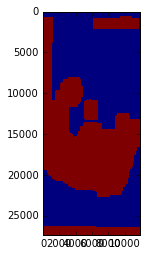

In [104]:
print mask.shape
plt.imshow(mask)
plt.show()

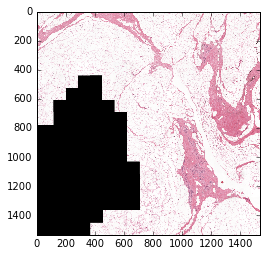

In [12]:
positions = [(40960, 102400, 1536, 1536)]
sampler = WSIParallelSampler(WSI_PATH, data_level=4, multiprocess=True, n_producers=1)
sampler.set_todo_positions(positions)
for im in sampler:
    plt.imshow(im.transpose(1,2,0))



```
D_LEVEL=6
P_SIZE=420

# Show equivalence between overlapping and non-overlapping patch generator
sampler = WSIParallelSampler(WSI_PATH, data_level=D_LEVEL, multiprocess=True, n_producers=1)
s = (2**D_LEVEL)*P_SIZE
positions = [(44000,120000,P_SIZE,P_SIZE),
             (44000,int(120000+s*0.5),P_SIZE,P_SIZE),
             (44000,int(120000+s*2*0.5),P_SIZE,P_SIZE),
             
             (44000+s,120000,P_SIZE,P_SIZE), 
             (44000+s,int(120000+s*0.5),P_SIZE,P_SIZE),
             (44000+s,int(120000+s*2*0.5),P_SIZE,P_SIZE),
            
            (44000+s,int(120000+s*4*0.5),P_SIZE,P_SIZE)]

gen = overlapping_patch_generator(sampler, positions, P_SIZE*3, D_LEVEL)

sampler = WSIParallelSampler(WSI_PATH, data_level=D_LEVEL, multiprocess=True, n_producers=1)
sampler.set_todo_positions(positions)
it = iter(sampler)

for im in gen:
    im2 = next(it)
    plot_image = np.hstack((im.transpose(1,2,0), im2.transpose(1,2,0)))
    
    plt.imshow(plot_image)
    plt.show()
    
```


In [13]:
def indices_full_black(positions, mask, image_dims):
    indices = []
    mask = mask.transpose(1,0)
    scale_factor = int(np.round(image_dims[0]/mask.shape[0]))
    
    for i, pos in enumerate(positions):
        pos = (np.array(pos)/scale_factor).astype(np.int32)
        if np.sum(mask[pos[0]:pos[0]+pos[2], pos[1]:pos[1]+pos[2]]) == 0:
            indices.append(i)
    return indices
        

In [108]:
PATCH_SIZE = 768
STRIDE = 128
DATA_LEVEL = 1

        
#sampler = WSIParallelSampler('/mnt/diskA/guido/slides/T13-37-I9-1.mrxs', data_level=1, multiprocess=True, n_producers=12)
sampler = WSIParallelSampler(WSI_PATH, data_level=DATA_LEVEL, multiprocess=True, n_producers=8, max_queue_size=16)
#sampler = WSIParallelSampler(WSI_PATH, data_level=DATA_LEVEL, multiprocess=False, n_producers=8, max_queue_size=16)

positions, prediction_shape = generate_patch_positions(image_dims[0], image_dims[1], PATCH_SIZE, STRIDE, DATA_LEVEL)

background_indices = indices_full_black(positions, mask, image_dims)

#non_background_positions = filter(lambda (i,pos): i not in background_indices, zip(range(len(positions)),positions))

bg = np.zeros((len(positions,)))
bg[background_indices] = 1

non_background_positions = [positions[p] for p in range(len(positions)) if bg[p] == 0]

n_patches = len(positions)

print "Image size", image_dims
print "Amount of patches to predict: ", n_patches
print "Amount of black patches:", len(background_indices), "N remaining", len(non_background_positions)
print "Prediction shape", prediction_shape

assert n_patches == np.product(prediction_shape)
assert len(background_indices)+len(non_background_positions) == n_patches

Image size (95310L, 218682L)
Amount of patches to predict:  318915
Amount of black patches: 174999 N remaining 143916
Prediction shape [373 855]


In [109]:
def non_background_patch_generator(n, source_generator, background_indices):
    
    bg = np.zeros((len(positions,)))
    bg[background_indices] = 1
    
    it = iter(source_generator)
    
    for i in xrange(n):
        if bg[i]==1:
            #yield None
            continue
        else:
            yield (i, next(it))

            
            

def overlapping_patch_generator(sampler, positions, patch_size_super, data_level):
    new_positions = []
    
    scale_factor = 2**data_level
    
    for pos in positions:
        new_positions.append( (pos[0]//scale_factor, pos[1]//scale_factor, pos[2], pos[3]) )
    
    positions = new_positions
    
    
    patch_size = positions[0][2]
    
    positions_to_sample = []
    positions_in_super = []

    offsets = [None]*len(positions)
        
    # Indices we still have to account for in super patches
    positions_todo = range(len(positions))
    
    
    print "Generating super patches (for positions N", len(positions), ")"
    
    while len(positions_todo) > 0:
        
        start_pos_index = positions_todo.pop(0)
        
        #Positions captured in super patch
        positions_in_current = []
        positions_in_current.append(start_pos_index)
        offsets[start_pos_index] = (0,0)
        
        
        start_pos = positions[start_pos_index]
        x = start_pos[0] #X of super patch
        y = start_pos[1]
        
        x_max = x + patch_size_super
        y_max = y + patch_size_super
        
        x_patch_size = patch_size
        y_patch_size = patch_size
            
        for p_index in positions_todo:
            p = positions[p_index]
            
            # Patch fits in max size of larger patch
            if ((p[0] >= x and p[0]+patch_size <= x_max) and
                (p[1] >= y and p[1]+patch_size <= y_max)):
            
                # Update to larger patch size if necessary
                x_patch_size = max(x_patch_size, p[0]+patch_size-x)
                y_patch_size = max(y_patch_size, p[1]+patch_size-y)  
                

                offsets[p_index] = (p[0]-x, p[1]-y)
                positions_in_current.append(p_index)
                
            # Because the positions are in order we can stop looking here.
            if (p[0]+patch_size > x_max and
                p[1]+patch_size > y_max):
                break
                
                
                
        positions_to_sample.append( (x*scale_factor, y*scale_factor, x_patch_size, y_patch_size) )
        positions_in_super.append(positions_in_current)
        positions_todo = [index for index in positions_todo if index not in positions_in_current]
        
    
    print "N positions to sample", len(positions_to_sample)
    #print positions_to_sample

    
    
    # Make some assertions to make sure all positions are valid
    for p_indices, sample_pos in zip(positions_in_super, positions_to_sample)[5:6]:
        for p in p_indices:
            try:
                assert sample_pos[2] - offsets[p][0] >= patch_size
                assert sample_pos[3] - offsets[p][1] >= patch_size
            except:
                print "Assertion failed for position index ", p
            
    
    
    sampler.set_todo_positions(positions_to_sample)
    
    it = iter(sampler)
    pos_it = iter(positions_to_sample)
    
    ready_patches = [None]*len(positions)

    def gen():
        for p_index in xrange(len(positions)):


            if ready_patches[p_index] is None:
                super_patch = next(it)
                #super_patch_dims = next(pos_it)

                indices = positions_in_super.pop(0)

                #print super_patch_dims, dims, super_patch.shape
                for i in indices:
                    offset = offsets[i]
                    
                    # X and Y are reversed here!!! Strange ordering in MIR
                    patch = super_patch[:, offset[1]:offset[1]+patch_size, offset[0]:offset[0]+patch_size]
                        
                    ready_patches[i] = patch
                    
                    
            yield ready_patches[p_index]

            # Unload from memory
            ready_patches[p_index] = None
            
    return gen()
        
        
    
    
super_generator = overlapping_patch_generator(sampler, non_background_positions, patch_size_super=2048, data_level=DATA_LEVEL)
my_generator = non_background_patch_generator(len(positions), super_generator, background_indices)


Generating super patches (for positions N 143916 )
N positions to sample 1326


In [110]:
import itertools
import util


BATCH_SIZE = 48
n_batches = int(np.ceil(n_patches/BATCH_SIZE))
n_non_background = n_patches - len(background_indices)

#prediction_flat = np.zeros(np.product(prediction_shape))

pred_flat_raw = np.zeros((np.product(prediction_shape),)+(3,))

images_in_batch = []
indices_in_batch = []

f = time.time()

for n, im in tqdm(my_generator, total=n_non_background, smoothing=0.1):   
    
    images_in_batch.append(im)
    indices_in_batch.append(n)
        
    if len(indices_in_batch) == BATCH_SIZE or n == n_non_background-1:
        image_batch = np.array(images_in_batch, dtype=np.float32)
    else:
        continue

    f = time.time()-f

    image_batch = util.normalize_image(image_batch)
    image_batch = util.zero_center(image_batch, P.MEAN_PIXEL).astype(np.float32)
    s = time.time()
    pred_binary, pred = predict_fn(image_batch)
    
    pred_flat_raw[indices_in_batch] = pred
    #print time.time()-s, (time.time()-s)/len(image_batch), f
    
    images_in_batch = []
    indices_in_batch = []
    
    f = time.time()
        

100%|██████████| 143916/143916 [6:33:08<00:00,  6.10it/s]


78914
(78914, 3)
(187, 422, 3)


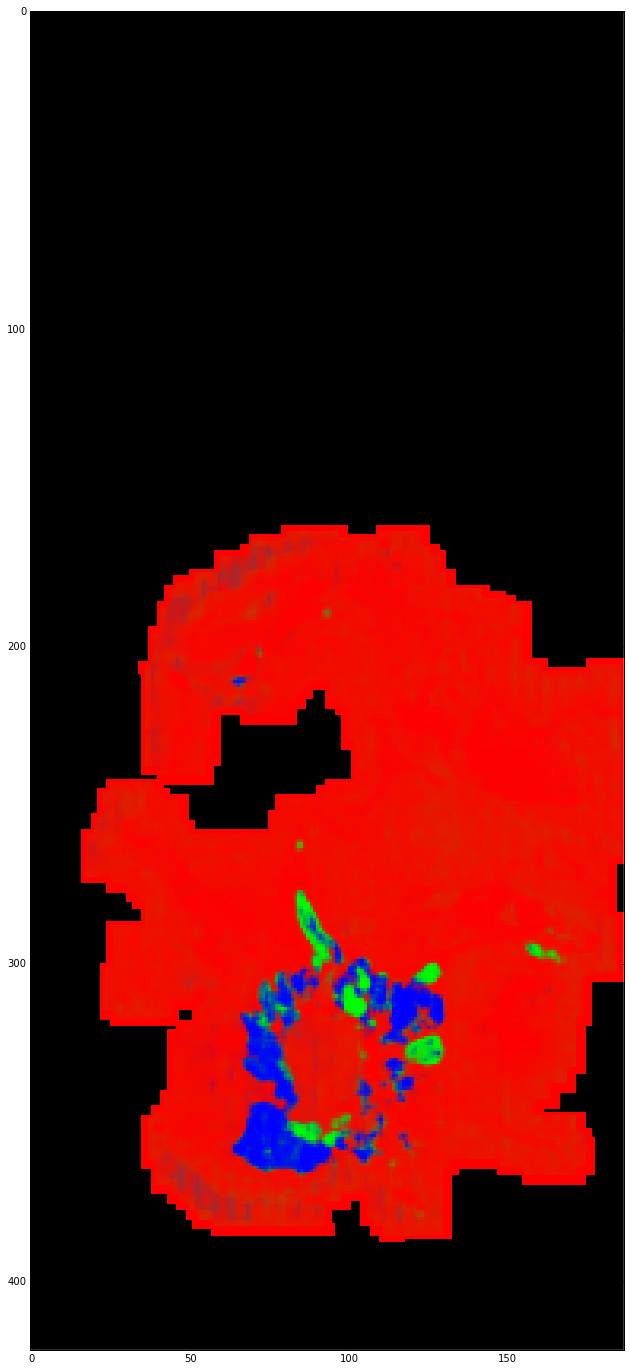

NameError: name 'prediction_flat' is not defined

In [97]:
#for x in preds_raw[300:600]:
#    print x

def first():
    class3_preds = pred_flat_raw
    #class3_preds = np.array(preds_raw)[:np.product(prediction_shape)]

    print class3_preds.shape
    print tuple(prediction_shape)+(3,)
    prediction_rgb = class3_preds.reshape(tuple(prediction_shape)+(3,), order='F')
    plt.figure(figsize=(12,24))
    prediction_rgb = prediction_rgb.transpose(1,0,2)
    plt.imshow(prediction_rgb, interpolation='none')
    plt.show()

print 187*422
first()


prediction = np.array(prediction_flat).reshape(prediction_shape, order='F') #Fortran order
prediction = prediction.transpose(1,0)
#3:19
plt.figure(figsize=(12,24))
plt.imshow(prediction, interpolation='none')
plt.show()

prediction = np.array(class3_preds[:,1]).reshape(prediction_shape, order='F') #Fortran order
prediction = prediction.transpose(1,0)
#3:19
plt.figure(figsize=(12,24))
plt.imshow(prediction, interpolation='none')
plt.show()




In [ ]:
plt.imshow(prediction)
plt.show()